In [0]:
import matplotlib as mpl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models
import seaborn as sns
sns.set()

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

def printmd(s):
    display(Markdown(s))

from keras.datasets import cifar10
optimizer = optimizers.sgd(lr=0.0001)
EPOCHS = 20


# Leitura dos Dados

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Exemplo dos Dados

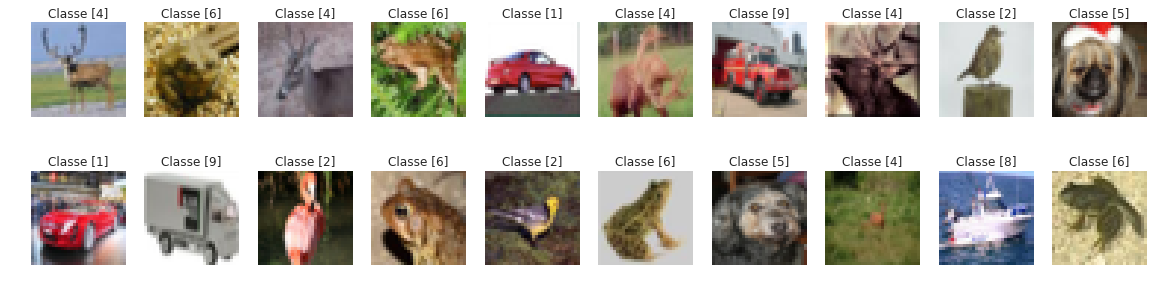

In [0]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].set_title("Classe {}".format(y_train[img_i]))
        axes[i][j].axis("off")
plt.show()

In [0]:
# Normaliza a intensidade dos pixels para o intervalo [0, 1]
x_train = x_train/255
x_test = x_test/255


# Separação Em Grupos
O grupo B irá conter as classes 0 e 7

In [0]:
# Transformando as classes de imagens em one-hot encoding
# e alterando o formato das entradas
y_train =  np.reshape(y_train, (len(y_train)))
y_test =  np.reshape(y_test, (len(y_test)))
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_train = y_train.values
y_test = y_test.values


In [0]:
y_test.shape

(10000, 10)

In [0]:
x_test.shape

(10000, 32, 32, 3)

In [0]:
# Aqui iremos separar os conjuntos em A e B

#Listas que irao armazenar x e y de treino e teste para cada conjunto
Ax_train = []
Ay_train = []
Ax_test = []
Ay_test = []

Bx_train = []
By_train = []
Bx_test = []
By_test = []

# como transformamos em one-hot, precisamos dessa funcao para
# recuperar qual a classe de uma imagem
def get_index(x):
  for i in range(len(x)):
    if(x[i]==1):
      return i
    
for i in range(len(y_test)):
  if(get_index(y_test[i])==0 or get_index(y_test[i])==7):
    By_test.append(y_test[i])
    Bx_test.append(x_test[i])
  else:
    Ay_test.append(y_test[i])
    Ax_test.append(x_test[i])
    
for i in range(len(y_train)):
  if(get_index(y_train[i])==0 or get_index(y_train[i])==7):
    By_train.append(y_train[i])
    Bx_train.append(x_train[i])
  else:
    Ay_train.append(y_train[i])
    Ax_train.append(x_train[i])
    

# Para facilitar operacoes, transformamos as listas obtidas em numpy arrays
By_test = np.array(By_test)
Bx_test = np.array(Bx_test)

Ay_test = np.array(Ay_test)
Ax_test = np.array(Ax_test)

By_train = np.array(By_train)
Bx_train = np.array(Bx_train)

Ay_train = np.array(Ay_train)
Ax_train = np.array(Ax_train)

Bx_test.shape

(2000, 32, 32, 3)

## Legendas dos Gráficos
Nos gráficos gerados, as legendas seguem o seguinte padrão:

*   M 1: Modelo treinado com o conjunto A 
*   M 2: Modelo treinado com o conjunto B, sem transfer learning
*   M 3: Modelo treinado com o conjunto B, com fine tunning em uma camada
*   M 4 Modelo treinado com o conjunto B, com fine tunning em duas camadas


# Rede Treinada Com Conjunto A

Abaixo, criamos uma rede do tipo CNN com quatro camadas de convolução e duas de Max Pooling, além de duas camadas Fully Connected ao final. Para todas as camadas utilizamos a função de ativação ReLU, menos para a última, que utiliza a função de ativação softmax. Também são utilizadas duas camadas de dropout para regularizar o modelo.

In [0]:
n_classes = 10
modelA = models.Sequential()
modelA.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1", input_shape=(32,32,3)))
modelA.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2"))
modelA.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool1"))

modelA.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3"))
modelA.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4"))
modelA.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool2"))


modelA.add(layers.Flatten(name="Flatten"))
modelA.add(layers.Dense(128, activation="relu", name="Dense1"))
modelA.add(layers.Dropout(0.4, name="Dropout"))
modelA.add(layers.Dense(n_classes, activation='softmax', name="Output"))
modelA.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
result_a = modelA.fit(Ax_train,Ay_train,verbose=1,epochs=EPOCHS,validation_data=(Ax_test,Ay_test))

Train on 40000 samples, validate on 8000 samples
Epoch 1/20
40000/40000 [==============================] - 11s 285us/step - loss: 2.2754 - acc: 0.1356 - val_loss: 2.2531 - val_acc: 0.1694
Epoch 2/20
40000/40000 [==============================] - 9s 215us/step - loss: 2.2314 - acc: 0.1402 - val_loss: 2.1984 - val_acc: 0.1609
Epoch 3/20
40000/40000 [==============================] - 9s 216us/step - loss: 2.1793 - acc: 0.1400 - val_loss: 2.1416 - val_acc: 0.1564
Epoch 4/20
40000/40000 [==============================] - 9s 217us/step - loss: 2.1415 - acc: 0.1438 - val_loss: 2.1054 - val_acc: 0.1827
Epoch 5/20
40000/40000 [==============================] - 9s 216us/step - loss: 2.1278 - acc: 0.1426 - val_loss: 2.0866 - val_acc: 0.2049
Epoch 6/20
40000/40000 [==============================] - 9s 216us/step - loss: 2.1168 - acc: 0.1500 - val_loss: 2.0733 - val_acc: 0.2062
Epoch 7/20
40000/40000 [==============================] - 9s 216us/step - loss: 2.1050 - acc: 0.1574 - val_loss: 2.0617 - 

In [0]:
# Aqui definimos uma função auxiliar para plotar graficos ou de loss ou de 
# acuracia para um mesmo modelo
def plot_acc_loss(result,title,label1,label2,type_label):
  train_acc = result.history[type_label]
  test_acc = result.history["val_"+type_label]
  epochs_list = list(range(1,len(train_acc)+1))
  plt.plot(epochs_list,train_acc,color="r",label=label1)
  plt.plot(epochs_list,test_acc,color="b",label=label2)
  plt.xticks(epochs_list)
  plt.legend()
  plt.title(title)
  plt.show()
  
# A função abaixo plota a acuaracia e loss em teste
# para poder observar uma diminuindo enquanto a outra cresce

def plot_compare_acc_loss(result,title):
  test_acc = result.history["val_acc"]
  test_loss = result.history["val_loss"]
  epochs_list = list(range(1,len(test_acc)+1))
  plt.plot(epochs_list,test_acc,color="r",label="Test Acc")
  plt.plot(epochs_list,test_loss,color="b",label="Test Loss")
  plt.xticks(epochs_list)
  plt.legend()
  plt.title(title)
  plt.show()


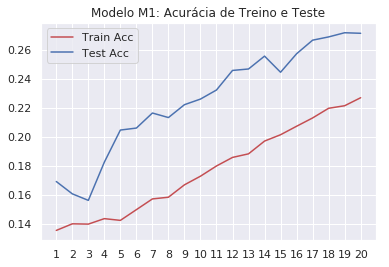

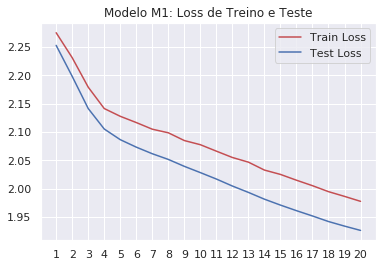

In [0]:
plot_acc_loss(result_a,"Modelo M1: Acurácia de Treino e Teste","Train Acc","Test Acc","acc")
plot_acc_loss(result_a,"Modelo M1: Loss de Treino e Teste","Train Loss","Test Loss","loss")

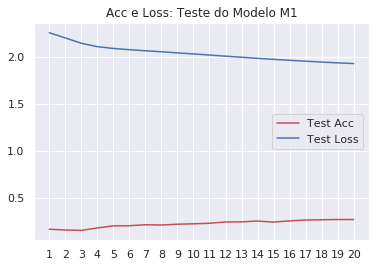

In [0]:
plot_compare_acc_loss(result_a,"Acc e Loss: Teste do Modelo M1")

É possível observar que o modelo converge corretamente, com loss diminuindo e acurácia aumentando.

# Sem transfer learning

Para esta rede, utilizamos a mesma arquitetura da rede anterior. Porém, esta rede será treinada com os dados do conjunto B e não faz uso de transfer learning.


In [0]:
# Como ficaria a mesma rede usando a forma sequencial
n_classes = 10
modelB = models.Sequential()
modelB.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1", input_shape=(32,32,3)))
modelB.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2"))
modelB.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool1"))

modelB.add(layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3"))
modelB.add(layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4"))
modelB.add(layers.MaxPooling2D(pool_size=(2, 2), name="Pool2"))


modelB.add(layers.Flatten(name="Flatten"))
modelB.add(layers.Dense(128, activation="relu", name="Dense1"))
modelB.add(layers.Dropout(0.4, name="Dropout"))
modelB.add(layers.Dense(n_classes, activation='softmax', name="Output"))
modelB.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



In [0]:
result_b1 = modelB.fit(Bx_train,By_train,verbose=1,epochs=EPOCHS,validation_data=(Bx_test,By_test))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 501us/step - loss: 2.1978 - acc: 0.2107 - val_loss: 2.0946 - val_acc: 0.4985
Epoch 2/20
10000/10000 [==============================] - 2s 216us/step - loss: 1.9414 - acc: 0.4867 - val_loss: 1.7060 - val_acc: 0.5000
Epoch 3/20
10000/10000 [==============================] - 2s 218us/step - loss: 1.4187 - acc: 0.5055 - val_loss: 1.0615 - val_acc: 0.5000
Epoch 4/20
10000/10000 [==============================] - 2s 220us/step - loss: 0.9767 - acc: 0.5155 - val_loss: 0.7932 - val_acc: 0.5190
Epoch 5/20
10000/10000 [==============================] - 2s 218us/step - loss: 0.8552 - acc: 0.5128 - val_loss: 0.7304 - val_acc: 0.5775
Epoch 6/20
10000/10000 [==============================] - 2s 220us/step - loss: 0.8061 - acc: 0.5228 - val_loss: 0.7055 - val_acc: 0.5990
Epoch 7/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.7697 - acc: 0.5392 - val_loss: 0.6908 - v

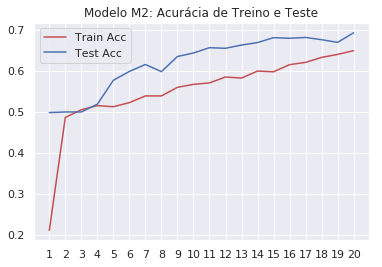

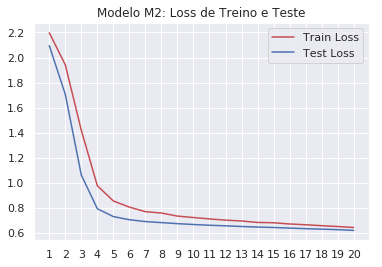

In [0]:
plot_acc_loss(result_b1,"Modelo M2: Acurácia de Treino e Teste","Train Acc","Test Acc","acc")
plot_acc_loss(result_b1,"Modelo M2: Loss de Treino e Teste","Train Loss","Test Loss","loss")

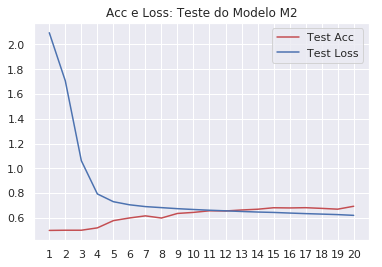

In [0]:
plot_compare_acc_loss(result_b1,"Acc e Loss: Teste do Modelo M2")

O modelo converge corretamente, com loss diminuindo e acurácia aumentando, sem overfit.

# Fine-tuning em uma camada
Agora, iremos reutilizar os pesos obtidos ao treinar o modelo com os dados do conjunto A. Entretanto, iremos treinar apenas a última camada fully connected. Para isso, escolhemos remover a ultima camada, congelar os pesos da rede, adicionar uma nova camada fully connected idêntica a que foi removida, que será treinada agora com os dados do conjunto B.

In [0]:

modelA.pop()
modelA.trainable = False
modelA.add(layers.Dense(n_classes, activation='softmax', name="Output2"))
modelA.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [0]:
result_b2 = modelA.fit(Bx_train,By_train,epochs=EPOCHS,validation_data=(Bx_test,By_test))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 504us/step - loss: 1.1499 - acc: 0.4843 - val_loss: 0.7550 - val_acc: 0.5920
Epoch 2/20
10000/10000 [==============================] - 2s 219us/step - loss: 0.8151 - acc: 0.5273 - val_loss: 0.6985 - val_acc: 0.6050
Epoch 3/20
10000/10000 [==============================] - 2s 216us/step - loss: 0.7655 - acc: 0.5464 - val_loss: 0.6777 - val_acc: 0.6260
Epoch 4/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.7440 - acc: 0.5553 - val_loss: 0.6654 - val_acc: 0.6500
Epoch 5/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.7224 - acc: 0.5708 - val_loss: 0.6550 - val_acc: 0.6595
Epoch 6/20
10000/10000 [==============================] - 2s 219us/step - loss: 0.7118 - acc: 0.5762 - val_loss: 0.6463 - val_acc: 0.6700
Epoch 7/20
10000/10000 [==============================] - 2s 216us/step - loss: 0.7049 - acc: 0.5848 - val_loss: 0.6386 - v

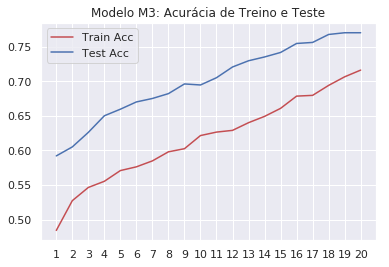

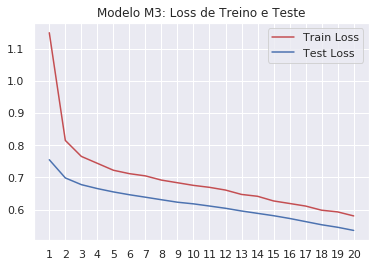

In [0]:
plot_acc_loss(result_b2,"Modelo M3: Acurácia de Treino e Teste","Train Acc","Test Acc","acc")
plot_acc_loss(result_b2,"Modelo M3: Loss de Treino e Teste","Train Loss","Test Loss","loss")

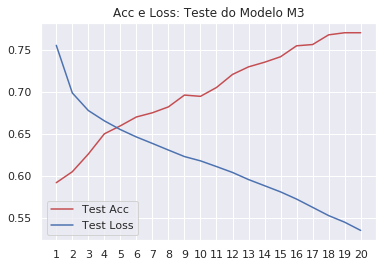

In [0]:
plot_compare_acc_loss(result_b2,"Acc e Loss: Teste do Modelo M3")

É possível observar que o modelo converge corretamente, sem sofrer de overfit.

# Fine-tuning em duas camadas
Para o último modelo a ser gerado, iremos realizar um procedimento similar ao da seção anterior, porém, realizaremos fine tunning nas duas últimas camadas fully connected.

In [0]:
modelA.pop()
modelA.pop()
modelA.pop()
modelA.trainable = False
modelA.add(layers.Dense(128, activation="relu", name="Dense2"))
modelA.add(layers.Dropout(0.4, name="Dropout23"))
modelA.add(layers.Dense(n_classes, activation='softmax', name="Output3"))
modelA.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

result_b3 = modelA.fit(Bx_train,By_train,epochs=EPOCHS,validation_data=(Bx_test,By_test))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 5s 512us/step - loss: 1.0983 - acc: 0.4920 - val_loss: 0.7030 - val_acc: 0.6950
Epoch 2/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.8015 - acc: 0.5630 - val_loss: 0.6515 - val_acc: 0.7375
Epoch 3/20
10000/10000 [==============================] - 2s 219us/step - loss: 0.7429 - acc: 0.5887 - val_loss: 0.6248 - val_acc: 0.7065
Epoch 4/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.7119 - acc: 0.6120 - val_loss: 0.6002 - val_acc: 0.7510
Epoch 5/20
10000/10000 [==============================] - 2s 215us/step - loss: 0.6779 - acc: 0.6417 - val_loss: 0.5826 - val_acc: 0.7675
Epoch 6/20
10000/10000 [==============================] - 2s 216us/step - loss: 0.6494 - acc: 0.6624 - val_loss: 0.5600 - val_acc: 0.7695
Epoch 7/20
10000/10000 [==============================] - 2s 216us/step - loss: 0.6180 - acc: 0.6922 - val_loss: 0.5407 - v

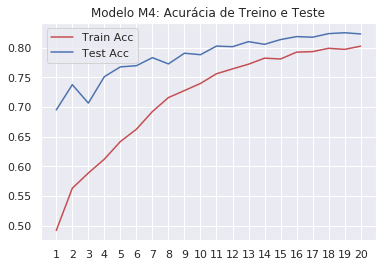

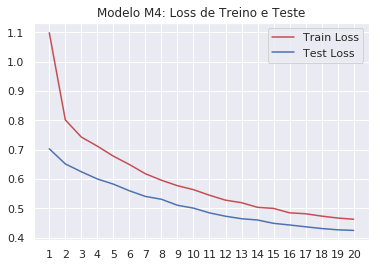

In [0]:
plot_acc_loss(result_b3,"Modelo M4: Acurácia de Treino e Teste","Train Acc","Test Acc","acc")
plot_acc_loss(result_b3,"Modelo M4: Loss de Treino e Teste","Train Loss","Test Loss","loss")

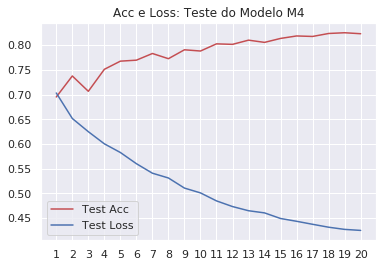

In [0]:
plot_compare_acc_loss(result_b3,"Acc e Loss: Teste do Modelo M4")

O modelo converge corretamente, sem overfit.

# Comparação de Resultados
Nesta seção, iremos comparar os resultados de cada modelo gerado.





### Comparação de Acurácia

In [0]:
# Aqui definimos uma funcao auxiliar para realizar o plot dos graficos comparativos

def compare_models(result_a,result_b1,result_b2,result_b3,label,title):
  list_a = result_a.history[label]
  list_b1 = result_b1.history[label]
  list_b2 = result_b2.history[label]
  list_b3 = result_b3.history[label]
  plt.plot(list_a,color="r",label="M 1")
  plt.plot(list_b1,color="b",label="M 2")
  plt.plot(list_b2,color="g",label="M 3")
  plt.plot(list_b3,color="y",label="M 4")
  plt.title(title)
  plt.xticks(list(range(1,len(list_a)+1)))
  plt.legend()
  plt.show()
  


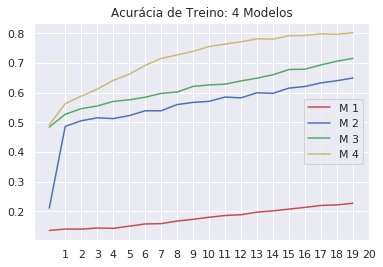

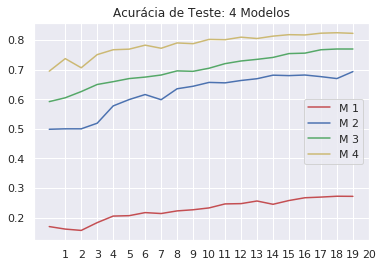

In [0]:
compare_models(result_a,result_b1,result_b2,result_b3,"acc","Acurácia de Treino: 4 Modelos")
compare_models(result_a,result_b1,result_b2,result_b3,"val_acc","Acurácia de Teste: 4 Modelos")

Como é possível observar, os dois modelos que fizeram uso de transfer learning obtiveram os melhores resultados, tanto para treino quanto para teste, sendo o melhor resultado aquele que realizou o fine tunning em 2 camadas, com os maiores valores de acurácia para treino e teste, sem causar overfit

### Comparação de Loss

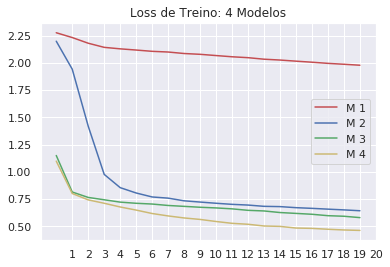

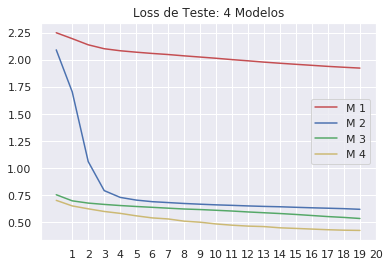

In [0]:
compare_models(result_a,result_b1,result_b2,result_b3,"loss","Loss de Treino: 4 Modelos")
compare_models(result_a,result_b1,result_b2,result_b3,"val_loss","Loss de Teste: 4 Modelos")

De forma análoga, os dois modelos com menores valores para loss, em treino e teste, são aqueles gerados utilizando fine tunning, sendo o melhor de todos o modelo M 4, que utiliza fine tunning em 2 camadas. Além disso, ao observar os gráficos comparativos de acurácia e de loss para os 4 modelos, é possível observar também que todos os modelos estão convergindo corretamente, sem causar overfit.

# Conclusão

Por fim, é possível observar que os melhores valores de acurácia e loss, para treino e teste, são obtidos ao utilizar transfer learning nas duas camadas fully connected. Esta performance pode ser explicada pois, ao utilizar uma rede com pesos pré treinados para as camadas de convolução, a rede já aprendeu a reconhecer padrões que são similares para objetos diferentes, como curvas e formatos. Ao utilizar transfer learning, adicionando apenas camadas fully connected ao final, estamos utilizando os formatos que a rede já aprendeu em um conjunto de dados para tentar aprender características que nos ajudem a reconhecer imagens de outro conjunto de dados distinto.

